Dropped:                 None -> R2: 0.5406, MSE: 117.81
Dropped:   social_media_hours -> R2: 0.5344, MSE: 119.39
Dropped:        netflix_hours -> R2: 0.5269, MSE: 121.33
Dropped: attendance_percentage -> R2: 0.5452, MSE: 116.63
Dropped:          sleep_hours -> R2: 0.5166, MSE: 123.97
Dropped:         diet_quality -> R2: 0.5426, MSE: 117.28
Dropped:   exercise_frequency -> R2: 0.5063, MSE: 126.59


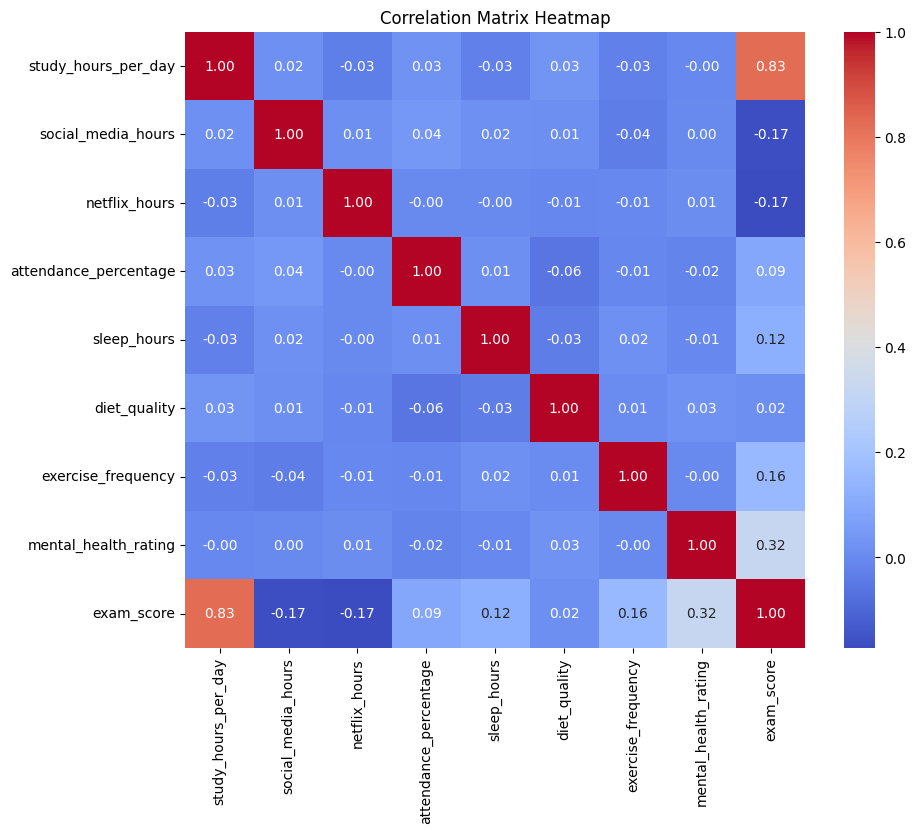

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9232\270418203.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_r2_scores[k] for k in kf_values], labels=[f"{k}-fold" for k in kf_values])


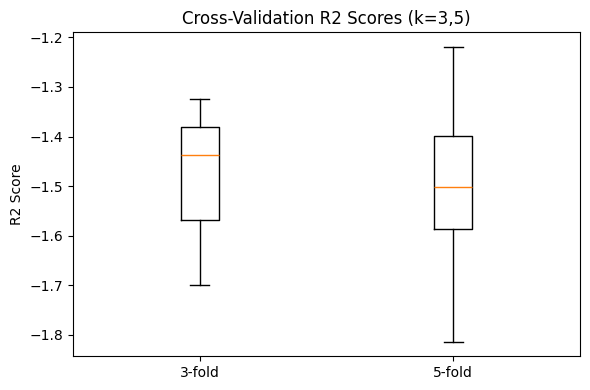

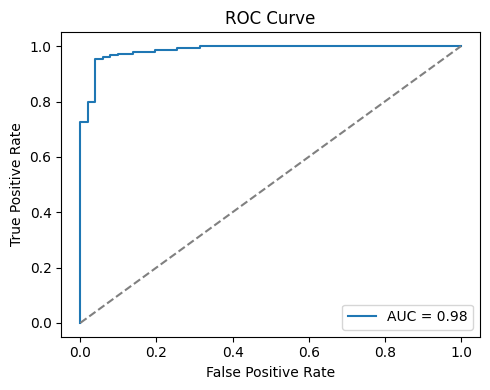

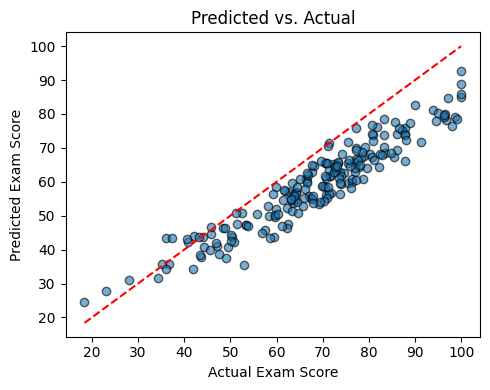

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# selected features
keep = ['study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'attendance_percentage', 'sleep_hours', 'diet_quality',
        'exercise_frequency', 'mental_health_rating', 'exam_score']

# load data
data = pd.read_csv('student_habits_performance.csv')[keep].dropna()
# Map diet quality to numerical values
data['diet_quality'] = data['diet_quality'].map({'Poor':1,'Fair':2,'Good':3})

features = [f for f in keep if f != 'exam_score']
always_include = ['study_hours_per_day', 'mental_health_rating']
drop_candidates = [f for f in features if f not in always_include]

# PyTorch training function
def train_regression(X_train, y_train, X_test, y_test, lr=0.001, epochs=500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = nn.Linear(X_train.shape[1], 1).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
    y_train_t = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1).to(device)

    for _ in range(epochs):
        model.train()
        preds = model(X_train_t)
        loss = criterion(preds, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(X_test.astype(np.float32)).to(device)).cpu().numpy().flatten()
    return y_pred

# Prepare data
X = data[features].values
y = data['exam_score'].values
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = {}
y_pred_full = None  

for drop_feat in ['None'] + drop_candidates:
    if drop_feat == 'None':
        # all features
        cols = features[:]   
    else:
        # drop one feature
        cols = [f for f in features if f != drop_feat]

    #Standardize training subset
    scaler = StandardScaler()
    X_tr_df = pd.DataFrame(X_train_full, columns=features)[cols]
    X_te_df = pd.DataFrame(X_test, columns=features)[cols]
    X_train = scaler.fit_transform(X_tr_df.values)
    X_test_sub = scaler.transform(X_te_df.values)
    # train the model
    y_pred = train_regression(X_train, y_train_full, X_test_sub, y_test, epochs=1000)
    if drop_feat == 'None':
        y_pred_full = y_pred.copy()

    # compute error metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[drop_feat] = {'R2': r2, 'MSE': mse}
    print(f"Dropped: {drop_feat:>20s} -> R2: {r2:.4f}, MSE: {mse:.2f}")

# Plot heatmap of correlations 
corr_data = data[keep].copy()
corr_matrix = corr_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# calcualte cross-validation R2 scores
kf_values = [3, 5]
cv_r2_scores = {k: [] for k in kf_values}

for k in kf_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train_full):
        X_tr_cv = X_train_full[train_idx]
        y_tr_cv = y_train_full[train_idx]
        X_val_cv = X_train_full[val_idx]
        y_val_cv = y_train_full[val_idx]

        scaler_cv = StandardScaler()
        X_tr_scaled = scaler_cv.fit_transform(X_tr_cv)
        X_val_scaled = scaler_cv.transform(X_val_cv)

        y_pred_cv = train_regression(X_tr_scaled, y_tr_cv, X_val_scaled, y_val_cv, epochs=500)
        cv_r2_scores[k].append(r2_score(y_val_cv, y_pred_cv))

        y_val_mean = np.full_like(y_val_cv, fill_value=y_tr_cv.mean(), dtype=np.float32)


# boxplot of R2 with k = 3,5 folds
plt.figure(figsize=(6,4))
plt.boxplot([cv_r2_scores[k] for k in kf_values], labels=[f"{k}-fold" for k in kf_values])
plt.ylabel('R2 Score')
plt.title('Cross-Validation R2 Scores (k=3,5)')
plt.tight_layout()
plt.show()

# calculate accuracy on test set
y_true_bin = (y_test >= 60).astype(int)
y_score_cont = y_pred_full   

# plot ROC curves
fpr, tpr, _ = roc_curve(y_true_bin, y_score_cont)
roc_auc = roc_auc_score(y_true_bin, y_score_cont)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#plot predicted vs actual exam scores
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred_full, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Predicted vs. Actual')
plt.tight_layout()
plt.show()

Confusion Matrix:
[[ 51   0]
 [ 49 100]]


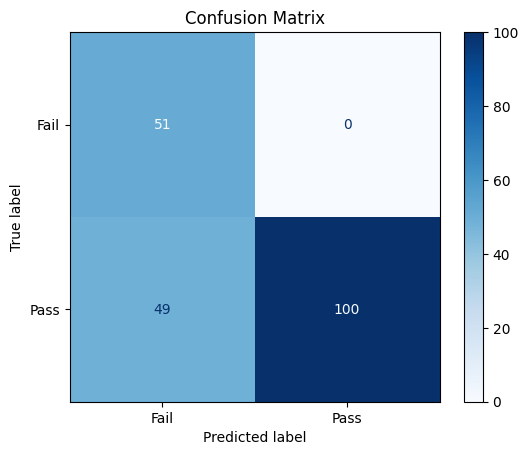

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Full model with all features to show confusion matrix
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test)
y_pred_full = train_regression(X_train_full_scaled, y_train_full, X_test_full_scaled, y_test, epochs=1000)
y_true_bin = (y_test >= 60).astype(int)
y_pred_bin = (y_pred_full >= 60).astype(int)

# Compute and display confusion matrix
cm_full = confusion_matrix(y_true_bin, y_pred_bin)
print('Confusion Matrix:')
print(cm_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_full, display_labels=['Fail','Pass'])
display_plot = disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [63]:
# two feature model with Torch using only study hours and mental health rating
small_keep = ['study_hours_per_day', 'mental_health_rating', 'exam_score']
small_df = pd.read_csv('student_habits_performance.csv')[small_keep].dropna()
X_small = small_df[['study_hours_per_day', 'mental_health_rating']].values.astype(np.float32)
y_small = small_df['exam_score'].values.astype(np.float32)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

# standardize inputs
scaler_s = StandardScaler()
X_train = scaler_s.fit_transform(X_train)
X_test = scaler_s.transform(X_test)

# train model
pred_small = train_regression(X_train, y_train, X_test, y_test, epochs=1000)

#print R2 and MSE for the two-feature model
r2_small = r2_score(y_test, pred_small)
mse_small = mean_squared_error(y_test, pred_small)
print(f"Only 2 best features - R2: {r2_small:.4f}, MSE: {mse_small:.2f}")

Only 2 features - R2: 0.4597, MSE: 138.54
